I implemented the Deep CNN model described in Salamon and Bello's paper (Salamon, Justin, and Juan Pablo Bello. "Deep convolutional neural networks and data augmentation for environmental sound classification." IEEE Signal processing letters 24.3 (2017): 279-283.) for eniornmental sound classification in this code. The data set used for this model is already processed in the other part of the code.

In [ ]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sn
import pandas as pd
import pickle
from librosa.feature import melspectrogram
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split

## Load from the saved data

In [ ]:
# For Colab only
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
X = np.load('gdrive/My Drive/CNN paper for sound classification/allfolds_features_x.npy')
y = np.load('gdrive/My Drive/CNN paper for sound classification/allfolds_labels_y.npy')

In [ ]:
# For Jupyter Notebook only
# X=np.load('UrbanSound8K\\UrbanSound8K_Processed\\allfolds_features_x.npy')
# y=np.load('UrbanSound8K\\UrbanSound8K_Processed\\allfolds_labels_y.npy')

In [ ]:
X_train_i, X_test, y_train_i, y_test = train_test_split(X, y, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train_i, y_train_i, test_size=0.25)


# Model

In [ ]:
frames = 128
bands = 128
feature_size = frames* bands 
num_channels = 1
num_labels = 10 # number of output predictions

In [ ]:
def build_model():
  f_size = 5
  model = Sequential()
  model.add(Convolution2D(24, (f_size, f_size), strides=(1,1), padding='valid', input_shape=(bands, frames, num_channels)))
  model.add(MaxPooling2D(pool_size=(4, 2)))
  model.add(Activation('relu'))
  model.add(Convolution2D(48, (5, 5), strides=(1,1), padding='valid'))
  model.add(MaxPooling2D(pool_size=(4, 2)))
  model.add(Activation('relu'))
  model.add(Convolution2D(48, (5, 5), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(64, kernel_regularizer=l2(0.001)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.5))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="SGD")
  return model

In [ ]:
print("Building model...")
model = build_model()
history = model.fit(X_train, y_train,validation_data=(X_val, y_val), batch_size=100, epochs=200)

Building model...
Epoch 1/200
53/53 [==============================] - 14s 67ms/step - loss: 2.8255 - accuracy: 0.1279 - val_loss: 2.3760 - val_accuracy: 0.2198
Epoch 2/200
53/53 [==============================] - 3s 53ms/step - loss: 2.3778 - accuracy: 0.1688 - val_loss: 2.2939 - val_accuracy: 0.2868
Epoch 3/200
53/53 [==============================] - 3s 53ms/step - loss: 2.3428 - accuracy: 0.1928 - val_loss: 2.2483 - val_accuracy: 0.3194
Epoch 4/200
53/53 [==============================] - 3s 53ms/step - loss: 2.3102 - accuracy: 0.2125 - val_loss: 2.1890 - val_accuracy: 0.3120
Epoch 5/200
53/53 [==============================] - 3s 52ms/step - loss: 2.2776 - accuracy: 0.2323 - val_loss: 2.1641 - val_accuracy: 0.3749
Epoch 6/200
53/53 [==============================] - 3s 53ms/step - loss: 2.2522 - accuracy: 0.2360 - val_loss: 2.1304 - val_accuracy: 0.3566
Epoch 7/200
53/53 [==============================] - 3s 59ms/step - loss: 2.2175 - accuracy: 0.2554 - val_loss: 2.0626 - val_accu

In [ ]:
pickle.dump(model, open('CNN_model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://cfabf96f-5b39-4131-b698-059b2987c6ef/assets


In [ ]:
# Downloading the Model from Colab to your system
from google.colab import files
files.download('CNN_model.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predicting using the saved model

In [ ]:
loaded_model = pickle.load(open('CNN_model.pkl', 'rb'))
result=loaded_model.predict(X_test)

## Evaluating the Model

Evaluating model...
55/55 [==============================] - 1s 10ms/step - loss: 0.6917 - accuracy: 0.8460

Accuracy = 0.8460217714309692


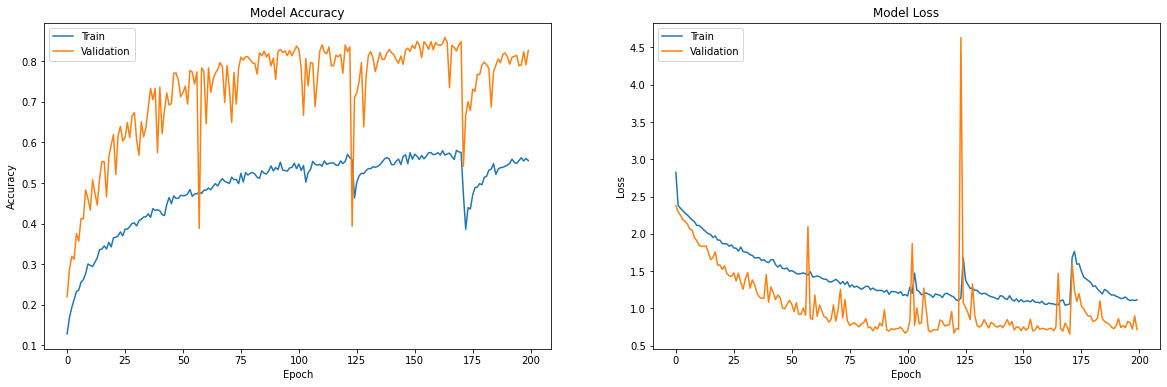

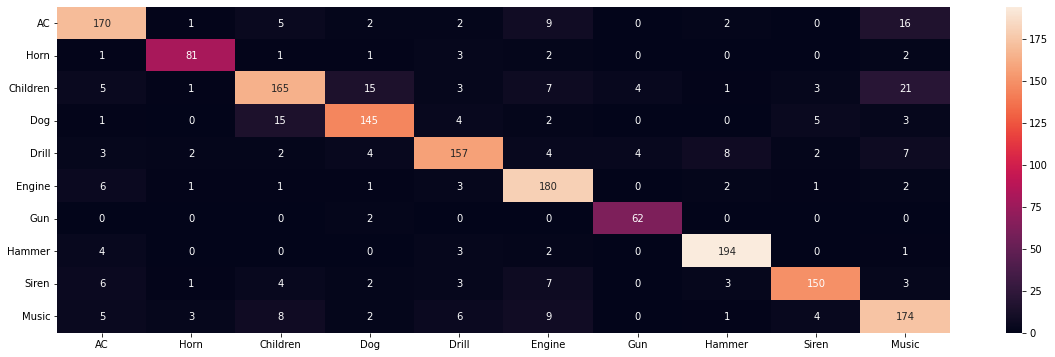

In [ ]:
print("Evaluating model...")
y_pred = np.argmax(model.predict(X_test, verbose=0),1)
y_true = np.argmax(y_test, 1)
accuracy = model.evaluate(X_test, y_test, batch_size=32)[1]
print("\nAccuracy = "+str(accuracy))

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

classes = ["AC","Horn","Children","Dog","Drill","Engine","Gun","Hammer","Siren","Music"] 
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred), classes, classes)
plt.figure(figsize=(20,6))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')

Box plot on 50 Epochs

In [ ]:
accuracy_array=[]

for i in range(1,11):
  print("Iteration...",i)
  X_train_i, X_test, y_train_i, y_test = train_test_split(X, y, test_size=0.20,random_state=40)
  X_train, X_val, y_train, y_val = train_test_split(X_train_i, y_train_i, test_size=0.25,random_state=40)
  print("Building model...")
  model = build_model()
  history = model.fit(X_train, y_train,validation_data=(X_val, y_val), batch_size=100, epochs=50)
  print("Evaluating model...")
  y_prob = model.predict(X_test, verbose=0)
  y_pred = np.argmax(y_prob,1)
  y_true = np.argmax(y_test, 1)
  _, accuracy = model.evaluate(X_test, y_test, batch_size=32)
  accuracy_array.append(accuracy)

Iteration... 1
Building model...
Epoch 1/50
53/53 [==============================] - 4s 60ms/step - loss: 3.5323 - accuracy: 0.1182 - val_loss: 2.4172 - val_accuracy: 0.1551
Epoch 2/50
53/53 [==============================] - 3s 51ms/step - loss: 2.4290 - accuracy: 0.1501 - val_loss: 2.3801 - val_accuracy: 0.2066
Epoch 3/50
53/53 [==============================] - 3s 51ms/step - loss: 2.4054 - accuracy: 0.1455 - val_loss: 2.3647 - val_accuracy: 0.2232
Epoch 4/50
53/53 [==============================] - 3s 51ms/step - loss: 2.3945 - accuracy: 0.1615 - val_loss: 2.3292 - val_accuracy: 0.2507
Epoch 5/50
53/53 [==============================] - 3s 51ms/step - loss: 2.3765 - accuracy: 0.1739 - val_loss: 2.2970 - val_accuracy: 0.2896
Epoch 6/50
53/53 [==============================] - 3s 51ms/step - loss: 2.3536 - accuracy: 0.1921 - val_loss: 2.2806 - val_accuracy: 0.2948
Epoch 7/50
53/53 [==============================] - 3s 51ms/step - loss: 2.3302 - accuracy: 0.2029 - val_loss: 2.2391 - v

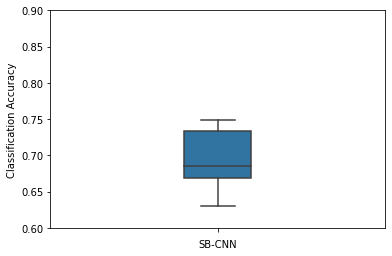

In [ ]:
boxplot=sn.boxplot(y=accuracy_array,width=0.2)
boxplot.set(ylabel='Classification Accuracy',xlabel='SB-CNN')
boxplot.set(ylim=(0.6, 0.9))
plt.show()